# Measuring Opioid Stigma Using the Twitter API and NLP

## Introduction
More than 100 Americans each day die from [opioid overdoses](https://www.cdc.gov/drugoverdose/epidemic/index.html). Expanding access to [medication assisted treatment (MAT)](http://adai.uw.edu/pubs/infobriefs/MAT.pdf) has the potential to help reverse the epidemic. However, [efforts to expand MAT have been blocked due to a stigmatized view of opioid addiction](https://www.vox.com/science-and-health/2017/7/20/15937896/medication-assisted-treatment-methadone-buprenorphine-naltrexone) as a moral failing rather than a medical condition.

Despite its importance, very little data is available on opioid-related stigma. This is in part because stigma is difficult to measure with traditional tools such as surveys, which may underestimate the pervasiveness of stigma due to [social desirability bias](https://en.wikipedia.org/wiki/Social_desirability_bias).

A potentially valuable source of data to fill this gap is unstructured text data from Twitter, which is [less likely to suffer from social desirability bias](http://journals.sagepub.com/doi/abs/10.1177/0049124115605339) than traditional surveys.

In order to tap into this data source, we can set up a listener that uses Twitter's [Streaming API](https://developer.twitter.com/en/docs/tweets/filter-realtime/overview) to track opioid-related tweets.

## Data Aquisition

### Scraping Twitter

In [ ]:
import logging
import tweepy
import dataset
from sqlalchemy.exc import ProgrammingError
from requests.packages.urllib3.exceptions import ReadTimeoutError
from textblob import TextBlob
import settings

logging.basicConfig(
    filename=f"logs/{__name__}.log",
    level=logging.DEBUG,
    format="%(name)s - %(asctime)s - %(levelname)s - %(message)s",
    filemode='w')
logger = logging.getLogger()
logger.info('Starting log...')

db = dataset.connect(settings.CONNECTION_STRING)


class StreamListener(tweepy.StreamListener):

    def on_status(self, status):
        if hasattr(status, 'retweeted_status'):
            return

        else:
            try:
                text = status.extended_tweet['full_text']
            except AttributeError:
                text = status.text
            created_utc = status.created_at
            favs = status.favorite_count
            followers = status.user.followers_count
            handle = status.user.screen_name
            loc = status.user.location
            rts = status.retweet_count
            tweet_id_str = status.id_str
            user_id_str = status.user.id_str

            blob = TextBlob(text)
            polarity = blob.sentiment.polarity
            subjectivity = blob.sentiment.subjectivity

            table = db[settings.TABLE_NAME]
            try:
                table.insert(dict(
                    tweet_id=tweet_id_str,
                    user_id=user_id_str,
                    handle=handle,
                    user_location=loc,
                    followers=followers,
                    text=text,
                    created_utc=created_utc,
                    favorites=favs,
                    retweets=rts,
                    polarity=polarity,
                    subjectivity=subjectivity,
                ))
            except ProgrammingError as err:
                logging.warning(err)

    def on_error(self, status_code):
        if status_code == 420:  # rate limiting
            return False


if __name__ == '__main__':
    # Authenticate using tokens defined in settings.py
    auth = tweepy.OAuthHandler(settings.TWITTER_APP_KEY,
                               settings.TWITTER_APP_SECRET)
    auth.set_access_token(settings.TWITTER_KEY, settings.TWITTER_SECRET)
    api = tweepy.API(auth)

    while True:
        try:
            stream_listener = StreamListener()
            stream = tweepy.Stream(auth=api.auth, listener=stream_listener,
                                   tweet_mode='extended')
            stream.filter(track=settings.TRACK_TERMS, languages=['en'],
                          stall_warnings=True)
        except ReadTimeoutError as err:
            logging.warning(err)
            continue


## Data Cleaning

### Load dataset

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import settings

conn = psycopg2.connect(settings.PSYCOPG2_CONNECTION)
df_all = pd.read_sql('select * from {}'.format(settings.TABLE_NAME), con=conn)

df_all.shape

(225983, 10)

### Restrict to tweets with identifiable US location

In [2]:
def clean_location(df):
    """Remove tweets where user does not have comma-separated location"""
    # Calculate total tweets and percent with location
    tweets_total = len(df)   
    with_location = len(df.loc[df['user_location'].notnull()])
    pct_with_location = with_location / tweets_total * 100
    
    # Keep only tweets with user_locations
    df = df.loc[df['user_location'].notnull()]
    
    # Count subset of tweets with location that include comma
    with_location_comma = len(df.loc[df['user_location'].str.contains(",", na=False)])
    pct_with_location_comma = with_location_comma / with_location * 100
    
    print(
        "Tweets with user location: {0} ({1:.0f}% of all tweets)\n"
        "Tweets with comma in user location: {2} ({3:.0f}% of tweets with location)".format(
            with_location, pct_with_location, with_location_comma, pct_with_location_comma)
    )
    
    # Keep only tweets where user_location contains a comma
    return df.loc[df['user_location'].str.contains(",")]

df_geo = clean_location(df_all)

Tweets with user location: 179103 (79% of all tweets)
Tweets with comma in user location: 113610 (63% of tweets with location)


In [3]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [4]:
# Split user location on first two commas
df_geo['user_location1'], df_geo['user_location2'], df_geo['user_location3'] = df_geo['user_location'].str.split(',', 2).str

# Remove leading and trailing whitespace
df_geo.user_location1 = df_geo.user_location1.str.strip()
df_geo.user_location2 = df_geo.user_location2.str.strip()

def capitalize_location(location):
    """Capitalize proper nouns and convert abbreviations to uppercase"""
    if location == None or not(isinstance(location, str)):
        return location
    elif len(location) <= 3:
        return location.upper()
    else:
        return location.title()
        
df_geo['user_location1'] = df_geo['user_location1'].apply(capitalize_location)
df_geo['user_location2'] = df_geo['user_location2'].apply(capitalize_location)

# Create new column containing state, which is user_location2 in most cases
df_geo['state'] = df_geo['user_location2']

# One exception is when user_location2 is "USA". In these cases, user_location1 is usually a state name
df_geo.loc[df_geo.state == 'USA', 'state'] = df_geo.user_location1

# Ensure that all states are represented by their postal abbreviations
df_geo = df_geo.replace({'state': us_state_abbrev})
df_geo.rename(columns={'state': 'state_abbrev'}, inplace=True)

df_geo[['user_location', 'user_location1', 'user_location2', 'state_abbrev']].head()

,user_location,user_location1,user_location2,state_abbrev
0,"Philadelphia, PA",Philadelphia,PA,PA
1,"Trenton, NJ",Trenton,NJ,NJ
7,"Red Hill, SC",Red Hill,SC,SC
8,"Little Rock, AR",Little Rock,AR,AR
10,"Port St Lucie, FL",Port St Lucie,FL,FL


In [5]:
def keep_usa(df):
    """Keep only rows where state is a U.S. postal abbreviation"""
    tweets_initial = len(df)
    
    tweets_usa = sum(df['state_abbrev'].isin(us_state_abbrev.values()))
    pct_usa = tweets_usa / tweets_initial * 100
    
    print(
        "Tweets with clean USA location: {0} ({1:.0f}% of tweets with comma-separated location)".format(
            tweets_usa, pct_usa)
    )
    
    return df.loc[df['state_abbrev'].isin(us_state_abbrev.values())]

df_usa = keep_usa(df_geo)
df_usa[['user_location','state_abbrev']].head()

Tweets with clean USA location: 88428 (78% of tweets with comma-separated location)


,user_location,state_abbrev
0,"Philadelphia, PA",PA
1,"Trenton, NJ",NJ
7,"Red Hill, SC",SC
8,"Little Rock, AR",AR
10,"Port St Lucie, FL",FL


### View sample of tweets for keyword groups

In [6]:
from IPython.display import display

# Change maximum display width of columns to see sample of tweets
pd.options.display.max_colwidth = 240

# Keyword groups
generic_opioid_keywords = 'opiate|opioid|opium'
other_opioid_keywords = 'codine|hydrocodone|morphine|opana|oxycodone|oxycontin|percocet|vicodin'
other_synthetic_keywords = 'carfentanil|fentanyl'

def keyword_sample(keywords,size=10):
    """Select sample of tweets containing specified keywords."""
    df_temp = df_usa.loc[df_usa['text'].str.contains(keywords, na=False)]
    return df_temp[['handle','user_location','text']].sample(n=size)

generic_opioid_sample = keyword_sample(generic_opioid_keywords,5)
print('Generic Opioid Sample:')
display(generic_opioid_sample)

heroin_sample = keyword_sample('heroin',5)
print('Heroin Sample:')
display(heroin_sample)

other_opioid_sample = keyword_sample(other_opioid_keywords,5)
print('Other Opioid Sample:')
display(other_opioid_sample)

methadone_sample = keyword_sample('methadone',5)
print('Methadone Sample:')
display(methadone_sample)

other_synthetic_sample = keyword_sample(other_synthetic_keywords,5)
print('Other Synthetic Sample:')
display(other_synthetic_sample)

Generic Opioid Sample:


,handle,user_location,text
127343,socrata,"Seattle, WA",Hear how @MonaSiddiquiMD from @HHSGov used a code-a-thon and data to approach the opioid crisis and help save lives. #SocrataConnect https://t.co/XTjJ3lLK2Q https://t.co/brg27a0zB3
192284,ChicagoCouncil,"Chicago, IL",The sense of the West's decline in world power links up viscerally with many people's loss of control in their daily lives. This cultural anxiety often manifests as racism or troubling statistics and trends such as the opioid crisis. @E...
75438,delilalaw,"Point Richmond, California","🙂 Marijuana legalization decreases opioid use, studies find #science #cannabis #medicine #health #opioids https://t.co/bcXGF0wNSh https://t.co/CboGpg0cDe"
37512,SousLeRadar,"Zelienople, PA","Study: Babies born in PA with opioid withdrawal symptoms up 1,000% since 2000\n\n(Via ABC27 News) https://t.co/nwWD1ONVws"
160435,ManiniAlex,"New York, USA","Study: Despite decline in prescriptions, #opioid deaths skyrocketing due to heroin and #synthetic drugs https://t.co/8KFtnp9Gcc"


Heroin Sample:


,handle,user_location,text
35685,MysticLady9160,"Indiana, USA",@SenWarren @RepCummings There is NO OPIATE CRISIS except for illegal heroin and fentanyl coming across our Southern Border. https://t.co/UWWXE3E4ot
66593,Jimi_Jammin,"Chicago, IL",@Brasilmagic I've smoked pot for over 40 years. I never tried or was even tempted to try heroin or other opioid derivatives.
133351,DailyNopioid,"Irving, TX",DA: Pregnant woman sold heroin to support own habit - News - The Times-Tribune https://t.co/u7xaW64nQC
22484,LibertyHrtRadio,"Shoreline, WA","@AGOWA doesn't like the legal residents of his State. He loves the felons, heroin addicts, and others who want him to ignore law, in their favor."
42759,bayofarizona,"San Diego, CA",@maiasz @joanwalsh I never understood lacing heroin with fentanyl either. Fentanyl was so much more expensive why would dealers give it away at the same price as black tar shit?


Other Opioid Sample:


,handle,user_location,text
3194,little_adalia,"Hamburg, NY","Just like nicotine, heroin, morphine\nSuddenly, I'm a fiend and you're all I need\nAll I need, yeah, you're all I need."
20454,chazisdead,"not where you are, sd",morphine
129489,AlexMMTri,"California, USA","@HKalodimos Minimum all 400 of ibuprofen, 5 of hydrocodone and 325 of Tylenol..."
68119,notsarahgreen,"Houston, TX","I still can’t believe bruno mars really sang “if you ever leave me baby, leave some morphine at my door” THE DRAMA OF IT ALL"
169323,usdrugsinfo,"Mattoon, IL","Buy cheap price oxycontin online in usa, best place to find source to purchase medicines online. Find all information about medications such as cost, dosage, color, side effects etc. Visit here- https://t.co/lrUxlydpPa"


Methadone Sample:


,handle,user_location,text
122556,Beyerstein,"Brooklyn, NY","@bIack_eye @Nicole_Cliffe It's crazy, isn't it? Those must be some powerful metabolic changes to methadone metabolism in pregnancy."
134091,opioid_info,"Nashville, TN",Comparison of buprenorphine and methadone in the treatment of opioid dependence | American Journal of Psychiatry https://t.co/40leUA8Daq
122081,OtreatmentPlans,"Port St Lucie, FL",methadone maintenance | Making Noise in the South https://t.co/Pg289tCxD3
103547,AddictionCentra,"Baltimore, MD",Comparison of buprenorphine and methadone in the treatment of opioid dependence | American Journal of Psychiatry https://t.co/I88WbCWA32
211622,RunningNEPA,"Pennsylvania, USA","@drdrew said on television that a young man SHOULD be on a medically assisted treatment such as methadone or suboxone and in the same breath said he’d understand why people would look down on him for being on said meds. As a Doctor, MAK..."


Other Synthetic Sample:


,handle,user_location,text
61639,hanselt,"Miami, Florida","My favorite ambassador!!! Thank you!! Miami had 1 more heroin death in the first 6 months of 2017, the state had 103. 10 fewer fentanyl deaths, state down 37. We had 77 more fentanyl analogue deaths, but broward had 127 more, west palm..."
175804,windowseat,"Minneapolis, MN","Dammit. I figured they wouldn't be able to find out who made &amp; who gave the counterfeit Vicodin (that was actually fentanyl) to Prince, but I'd hoped that part of why this took so long is maybe they had something."
32871,Dawn29_dawn,"Nebraska, USA","“There is no such thing as an opioid crisis. It is a fabricated term. People who are now dying from overdoses are now (most of the time) dying from fentanyl and its chemical cousins. A far better and more accurate term is ""the fentanyl ..."
21759,NewsTalk1049,"Biloxi, MS","The narcotics task force also seized guns, cash, and five pounds of fentanyl from a Central Park West apartment https://t.co/4zc5XljyzR https://t.co/4zc5XljyzR"
63298,sctuten,"South Carolina, USA",@AnnCoulter @realDonaldTrump and more dead from OD's of heroin and illicit fentanyl while the DEA keeps its head up its rectum and goes after LEGAL medicine!


## Analysis

### Count Tweets By State

In [7]:
# Remove tweets from bot account with Nebraska location
print("Percent of Nebraska tweets from @nopioids: " +
      str(format((len(df_usa.loc[df_usa['handle'] == 'Nopioids']) /
      len(df_usa.loc[df_usa['state_abbrev'] == 'NE'])) * 100, '.2f')))

df_usa = df_usa.loc[df_usa['handle'] != 'Nopioids']

Percent of Nebraska tweets from @nopioids: 80.61


In [8]:
def count_by_keyword_state(keywords,group_name):
    """Count tweets containing keyword groups by state"""
    df_temp = df_usa.loc[df_usa['text'].str.contains(keywords, na=False)]
    return df_temp.groupby('state_abbrev').size().reset_index(name='{}_tweets'.format(group_name))

generic_opioid_by_state = count_by_keyword_state(generic_opioid_keywords,'generic_opioid')
heroin_by_state = count_by_keyword_state('heroin','heroin')
other_opioid_by_state = count_by_keyword_state(other_opioid_keywords,'other_opioid')
methadone_by_state = count_by_keyword_state('methadone','methadone')
other_synthetic_by_state = count_by_keyword_state(other_synthetic_keywords,'other_synthetic')

# Merge
tweets_by_state = generic_opioid_by_state.merge(heroin_by_state,how='left',on='state_abbrev',validate='1:1')
tweets_by_state = tweets_by_state.merge(other_opioid_by_state,how='left',on='state_abbrev',validate='1:1')
tweets_by_state = tweets_by_state.merge(methadone_by_state,how='left',on='state_abbrev',validate='1:1')
tweets_by_state = tweets_by_state.merge(other_synthetic_by_state,how='left',on='state_abbrev',validate='1:1')

# Calculate total tweets
tweets_by_state['total_tweets'] = tweets_by_state.sum(axis=1)

tweets_by_state.head()

,state_abbrev,generic_opioid_tweets,heroin_tweets,other_opioid_tweets,methadone_tweets,other_synthetic_tweets,total_tweets
0,AK,37,33,4,1.0,7.0,82.0
1,AL,237,74,14,35.0,41.0,401.0
2,AR,178,20,10,NaN,22.0,230.0
3,AZ,366,131,32,8.0,55.0,592.0
4,CA,2080,773,189,51.0,316.0,3409.0


### Load and merge overdose data from CDC

In [9]:
# Import state opioid overdose totals from CDC
# https://wonder.cdc.gov/mcd-icd10.html
od_by_state_ucd = pd.read_csv('../data/cdc_wonder/state_opioid_od_total_2016.txt',
                              sep='\t', usecols=[*range(1,5),*range(7,9)],
                              skipfooter=62, engine='python')

# Clean column headers
od_by_state_ucd.rename(columns={'Deaths': 'deaths_total', 
                             'Age Adjusted Rate': 'adjusted_rate_total',
                             'Age Adjusted Rate Standard Error': 'adjusted_rate_se_total'}, inplace=True)

od_by_state_ucd.head()

,State,State Code,deaths_total,Population,adjusted_rate_total,adjusted_rate_se_total
0,Alabama,1,343,4863300,7.5,0.4
1,Alaska,2,94,741894,12.5,1.3
2,Arizona,4,769,6931071,11.4,0.4
3,Arkansas,5,169,2988248,5.9,0.5
4,California,6,2012,39250017,4.9,0.1


In [10]:
# Import state opioid overdose by drug type from CDC
# Note: Some deaths involve multiple drug types which is why these sum to more than the total
od_by_state_mcd = pd.read_csv('../data/cdc_wonder/state_opioid_od_substance_2016.txt',
                              sep='\t', usecols=[*range(1,4),*range(5,7),*range(9,11)],
                              skipfooter=74, engine='python')

# Keep only heroin
od_by_state_mcd = od_by_state_mcd.loc[od_by_state_mcd['Multiple Cause of death']=='Heroin']
od_by_state_mcd = od_by_state_mcd[od_by_state_mcd.columns.drop(od_by_state_mcd.filter(regex='Cause').columns)]

# Clean column headers
od_by_state_mcd.rename(columns={'Deaths': 'deaths_heroin', 
                             'Age Adjusted Rate': 'adjusted_rate_heroin',
                             'Age Adjusted Rate Standard Error': 'adjusted_rate_se_heroin'}, inplace=True)

od_by_state_mcd.head()

,State,State Code,deaths_heroin,Population,adjusted_rate_heroin,adjusted_rate_se_heroin
0,Alabama,1,126,4863300,2.8,0.3
5,Alaska,2,49,741894,6.5,0.9
9,Arizona,4,299,6931071,4.5,0.3
14,Arkansas,5,13,2988248,Unreliable,0.1
19,California,6,587,39250017,1.4,0.1


In [11]:
# Left merge since heroin data is missing for Montana, Nebraska, South Dakota, and Wyoming
od_by_state = od_by_state_ucd.merge(od_by_state_mcd,how='left',on=['State','State Code','Population'],validate='1:1')

# Clean column headers
od_by_state.columns = map(str.lower, od_by_state.columns)
od_by_state.rename(columns={'state': 'state_name', 'state code': 'fips'}, inplace=True)
od_by_state['state_abbrev'] = od_by_state['state_name'].map(us_state_abbrev)
cols = od_by_state.columns.tolist()
cols= cols[-1:] + cols[0:-1]
od_by_state = od_by_state[cols]

od_by_state.head()

,state_abbrev,state_name,fips,deaths_total,population,adjusted_rate_total,adjusted_rate_se_total,deaths_heroin,adjusted_rate_heroin,adjusted_rate_se_heroin
0,AL,Alabama,1,343,4863300,7.5,0.4,126.0,2.8,0.3
1,AK,Alaska,2,94,741894,12.5,1.3,49.0,6.5,0.9
2,AZ,Arizona,4,769,6931071,11.4,0.4,299.0,4.5,0.3
3,AR,Arkansas,5,169,2988248,5.9,0.5,13.0,Unreliable,0.1
4,CA,California,6,2012,39250017,4.9,0.1,587.0,1.4,0.1


In [12]:
# Merge with tweets_by_state
od_tweets_by_state = od_by_state.merge(tweets_by_state,on='state_abbrev',validate='1:1')

od_tweets_by_state['total_tweets_per_100k'] = ((od_tweets_by_state['total_tweets'] 
                                               / od_tweets_by_state['population']) * 10**5)

def calc_pct(df,numerator,denominator):
    """Calculate contribution of each keyword group to total"""
    return (df[numerator].divide(df[denominator], fill_value=0) * 100).round(1)

od_tweets_by_state['pct_generic_tweets'] = calc_pct(od_tweets_by_state,'generic_opioid_tweets','total_tweets')
od_tweets_by_state['pct_heroin_tweets'] = calc_pct(od_tweets_by_state,'heroin_tweets','total_tweets')
od_tweets_by_state['pct_rx_tweets'] = calc_pct(od_tweets_by_state,'other_opioid_tweets','total_tweets')
od_tweets_by_state['pct_methadone_tweets'] = calc_pct(od_tweets_by_state,'methadone_tweets','total_tweets')
od_tweets_by_state['pct_fentanyl_tweets'] = calc_pct(od_tweets_by_state,'other_synthetic_tweets','total_tweets')

od_tweets_by_state.head()

,state_abbrev,state_name,fips,deaths_total,population,adjusted_rate_total,adjusted_rate_se_total,deaths_heroin,adjusted_rate_heroin,adjusted_rate_se_heroin,...,other_opioid_tweets,methadone_tweets,other_synthetic_tweets,total_tweets,total_tweets_per_100k,pct_generic_tweets,pct_heroin_tweets,pct_rx_tweets,pct_methadone_tweets,pct_fentanyl_tweets
0,AL,Alabama,1,343,4863300,7.5,0.4,126.0,2.8,0.3,...,14,35.0,41.0,401.0,8.245430,59.1,18.5,3.5,8.7,10.2
1,AK,Alaska,2,94,741894,12.5,1.3,49.0,6.5,0.9,...,4,1.0,7.0,82.0,11.052792,45.1,40.2,4.9,1.2,8.5
2,AZ,Arizona,4,769,6931071,11.4,0.4,299.0,4.5,0.3,...,32,8.0,55.0,592.0,8.541249,61.8,22.1,5.4,1.4,9.3
3,AR,Arkansas,5,169,2988248,5.9,0.5,13.0,Unreliable,0.1,...,10,NaN,22.0,230.0,7.696818,77.4,8.7,4.3,0.0,9.6
4,CA,California,6,2012,39250017,4.9,0.1,587.0,1.4,0.1,...,189,51.0,316.0,3409.0,8.685347,61.0,22.7,5.5,1.5,9.3


### Figure 1: Visualization of Tweets per State with Breakdown by Drug Type

In [13]:
import plotly
import plotly.plotly as py

plotly.tools.set_credentials_file(username='mefryar', api_key='uORkhBM3WRj3Su4flGQm')

scl = [[0.0, 'rgb(242,240,247)'], [0.2, 'rgb(218,218,235)'], [0.4, 'rgb(188,189,220)'],
       [0.6, 'rgb(158,154,200)'], [0.8, 'rgb(117,107,177)'], [1.0, 'rgb(84,39,143)']]

od_tweets_by_state['text'] = '<br>' + od_tweets_by_state['state_name'] + '<br>' + '<br>' +\
            'Opioid/Opiate/Opium: ' + od_tweets_by_state['pct_generic_tweets'].astype(str) + '%' + '<br>' +\
            'Heroin: ' + od_tweets_by_state['pct_heroin_tweets'].astype(str) + '%' + '<br>' +\
            'Prescription Opioids: ' + od_tweets_by_state['pct_rx_tweets'].astype(str) + '%' + '<br>' +\
            'Fentanyl/Carfentanil: ' + od_tweets_by_state['pct_fentanyl_tweets'].astype(str) + '%' + '<br>' +\
            'Methadone: ' + od_tweets_by_state['pct_methadone_tweets'].astype(str) + '%'
            
data = [dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = False,
            locations = od_tweets_by_state['state_abbrev'],
            z = od_tweets_by_state['total_tweets_per_100k'].round(2),
            locationmode = 'USA-states',
            text = od_tweets_by_state['text'],
            marker = dict(
                line = dict(
                    color = 'rgb(255,255,255)',
                    width = 2
                )
            ),
            colorbar = dict(
                title = "Tweets per 100,000")
            )
        ]

layout = dict(
            title = '<b>Opioid-Related Tweets Per 100k</b><br>' + \
                    '(Hover for Breakdown of Opioid-Related Tweets)',
            geo = dict(
                scope='usa',
                projection=dict(type='albers usa'),
                showlakes = True,
                lakecolor = 'rgb(255, 255, 255)'
            )
        )
    
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='state-cloropleth-tweets')

### Figure 2: Relationship between Tweet Frequency and Overdose Deaths

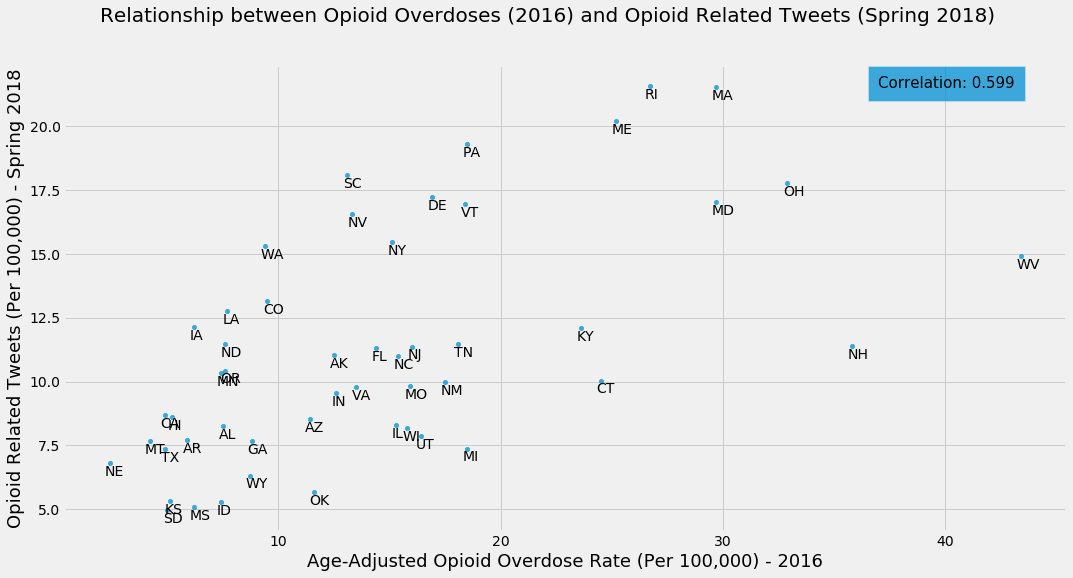

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

x = od_tweets_by_state.adjusted_rate_total.astype(float)
y = od_tweets_by_state.total_tweets_per_100k

plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(x,y, s=20, alpha=0.75)
for i, txt in enumerate(od_tweets_by_state['state_abbrev']):
    ax.annotate(txt, ((x[i]-0.2),(y[i]-0.5)))
    
ax.text(37, 21.5, 'Correlation: {}'.format(format(pearsonr(x, y)[0], '.3f')),
        bbox={'pad':10, 'alpha':0.75}, fontsize=15)
    
ax.set_xlabel('Age-Adjusted Opioid Overdose Rate (Per 100,000) - 2016', fontsize=18)
ax.set_ylabel('Opioid Related Tweets (Per 100,000) - Spring 2018', fontsize=18)
fig.suptitle('Relationship between Opioid Overdoses (2016) and Opioid Related Tweets (Spring 2018)', fontsize=20)

fig.savefig('../figures/scatter_tweets_overdoses.png', bbox_inches='tight')

## Conclusion

This first-stage analysis demonstrates that conversations taking place about opioids on Twitter are correlated with real-world public health outcomes, such as overdose deaths. A quick visual comparison of the choropleth of tweet frequency (Figure 1 above) with [choropleths of overdose death rates](https://www.cdc.gov/drugoverdose/data/statedeaths.html) reveals remarkable similarities. Plotting the relationship between tweet frequency and opioid overdose deaths (Figure 2) confirms that a positive correlation exists between these two indicators.

This is promising for subsequent analyses in which I will look not only at the frequency of these conversations but also their sentiment. Specifically, I plan to next look at measures of polarity and subjectivity before eventually developing a custom sentiment analysis algorithm that codes for stigma.

Other next steps include:
 - Analyzing the relationship between conversations about opioids and access to treatment
 - Analyzing the relationship between conversations that specifically mention treatment and access to treatment
 - Further refining data cleaning procedures to remove suspected bots